# Real Terrain Data


/var/folders/sq/czqm3zt15lb2_07cs887bdnw0000gn/T/ipykernel_88217/398399033.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


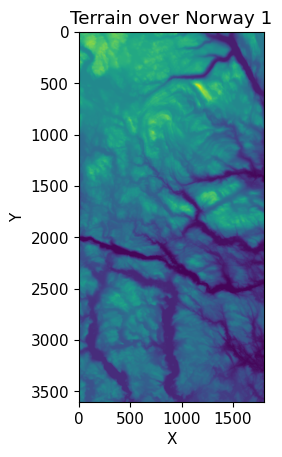

In [626]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge, Lasso

np.random.seed(1042)
plt.rcParams.update({'font.size': 11})
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Dimensions of terrain data: (3601, 1801)


/var/folders/sq/czqm3zt15lb2_07cs887bdnw0000gn/T/ipykernel_88217/3717423982.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


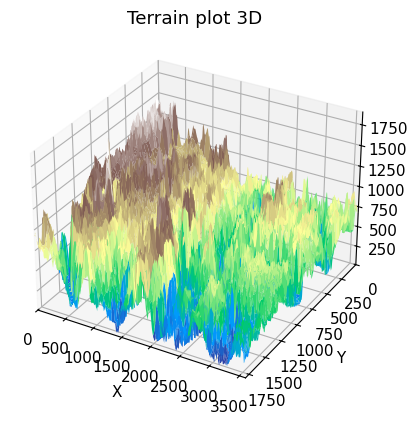

In [627]:
print("Dimensions of terrain data:", terrain1.shape)

from imageio import imread

terrain1 = imread('SRTM_data_Norway_1.tif')

fig = plt.figure()
ax = plt.axes(projection='3d')

x = np.arange(3601) 
y = np.arange(1801)  

X, Y = np.meshgrid(x, y)

plt.rcParams.update({'font.size': 11})

ax.plot_surface(X, Y, terrain1.T, cmap='terrain')

ax.set_xlim(0, 3601)
ax.set_ylim(1801, 0)

plt.title("Terrain plot 3D")
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig("Terrain_plot_3D.png")
plt.show()

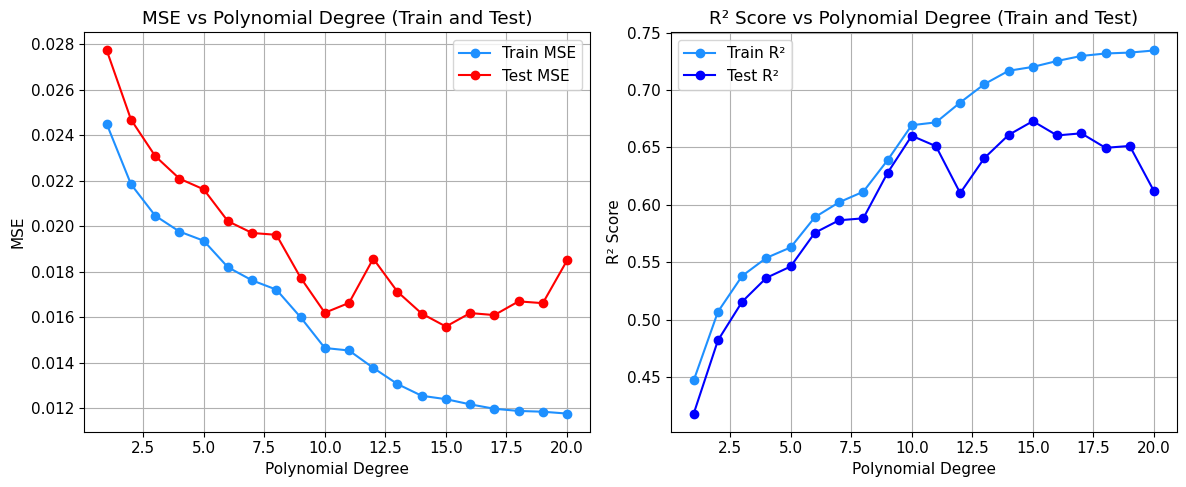

In [633]:
def min_max_scaling(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

num_points = 1700
points = np.column_stack((np.random.randint(0, terrain1.shape[0], size=num_points), np.random.randint(0, terrain1.shape[1], size=num_points)))

z = np.zeros([num_points, 1])
for i in range(num_points):
    z[i] = terrain1[int(points[i, 0]), int(points[i, 1])]

z_scaled = min_max_scaling(z).flatten()
x_scaled = min_max_scaling(points[:, 0])
y_scaled = min_max_scaling(points[:, 1])

# Create polynomial design matrix: From lecture Notes Week 35
def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int((i) * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x ** (i - k)) * (y ** k)

    return X


degree = 20
X = create_X(x_scaled, y_scaled, degree)

X_train, X_test, z_train, z_test = train_test_split(X, z_scaled, test_size=0.2, random_state=1042)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Center
z_train_mean = np.mean(z_train)
z_train_scaled = z_train - z_train_mean
z_test_scaled = z_test - z_train_mean


MSE_train_values = []
MSE_test_values = []
R2_train_values = []
R2_test_values = []

for i in range(1, degree + 1):
    c = int((i + 2) * (i + 1) / 2)
    X_tilde_train = X_train_scaled[:, :c]
    X_tilde_test = X_test_scaled[:, :c]
    
    beta = np.linalg.pinv(X_tilde_train.T @ X_tilde_train) @ X_tilde_train.T @ z_train_scaled
    
    y_train_pred = X_tilde_train @ beta + z_train_mean
    y_test_pred = X_tilde_test @ beta + z_train_mean
    
    MSE_train_values.append(mean_squared_error(z_train, y_train_pred))
    MSE_test_values.append(mean_squared_error(z_test, y_test_pred))
    R2_train_values.append(r2_score(z_train, y_train_pred))
    R2_test_values.append(r2_score(z_test, y_test_pred))

degrees = np.arange(1, degree + 1)

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, MSE_train_values, marker='o', label='Train MSE', color='dodgerblue')
plt.plot(degrees, MSE_test_values, marker='o', label='Test MSE', color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE vs Polynomial Degree (Train and Test)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(degrees, R2_train_values, marker='o', label='Train R²', color='dodgerblue')
plt.plot(degrees, R2_test_values, marker='o', label='Test R²', color='blue')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree (Train and Test)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

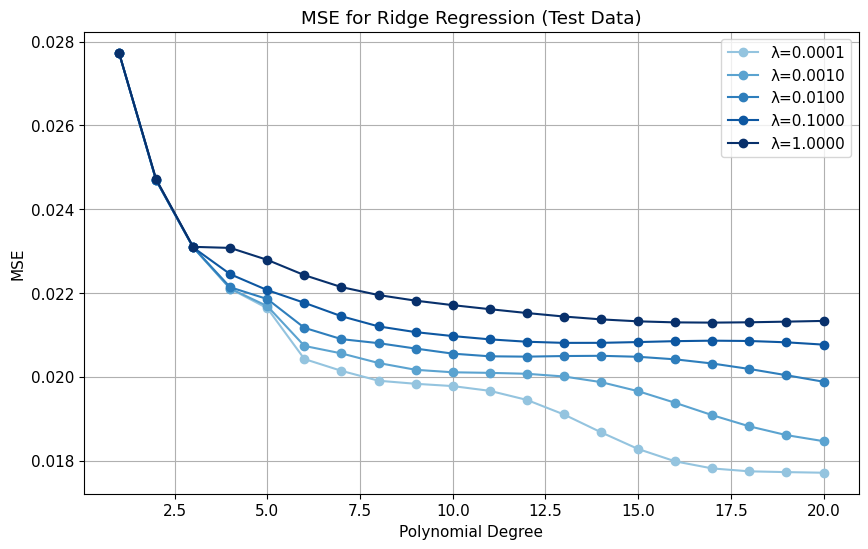

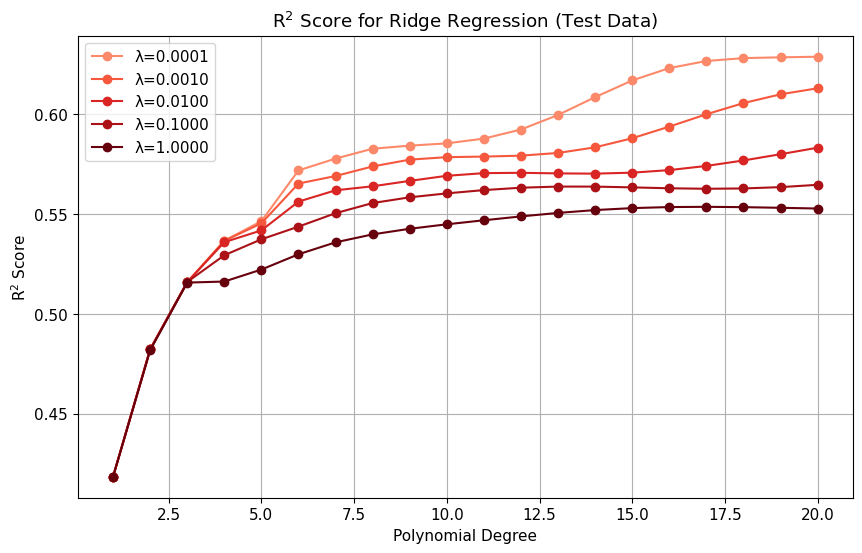

In [634]:
points_scaled = np.column_stack((min_max_scaling(points[:, 0]), min_max_scaling(points[:, 1])))
x = points_scaled[:, 0]
y = points_scaled[:, 1]

degrees = np.arange(1, 21) 
lambdas = np.logspace(-4, 0, 5) 

MSE_Ridge_train = np.zeros((len(degrees), len(lambdas)))
MSE_Ridge_test = np.zeros((len(degrees), len(lambdas)))
R2_Ridge_train = np.zeros((len(degrees), len(lambdas)))
R2_Ridge_test = np.zeros((len(degrees), len(lambdas)))

for i, deg in enumerate(degrees):
    X = create_X(x, y, n=deg)
    X = X[:, 1:] 

    # Train-test split
    X_train, X_test, z_train, z_test = train_test_split(X, z_scaled, test_size=0.2, random_state=1042)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Center
    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean

    p = X_train_scaled.shape[1]
    I = np.eye(p)

    for j, lmb in enumerate(lambdas):
        Ridgebeta = np.linalg.inv(X_train_scaled.T @ X_train_scaled + lmb * I) @ X_train_scaled.T @ z_train_scaled

        y_train_pred = X_train_scaled @ Ridgebeta + z_train_mean
        y_test_pred = X_test_scaled @ Ridgebeta + z_train_mean

        MSE_Ridge_train[i, j] = mean_squared_error(z_train, y_train_pred)
        MSE_Ridge_test[i, j] = mean_squared_error(z_test, y_test_pred)
        R2_Ridge_train[i, j] = r2_score(z_train, y_train_pred)
        R2_Ridge_test[i, j] = r2_score(z_test, y_test_pred)


mse_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lambdas)))
r2_colors = plt.cm.Reds(np.linspace(0.4, 1, len(lambdas)))

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, MSE_Ridge_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=mse_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for Ridge Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, R2_Ridge_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=r2_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$ Score for Ridge Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.048e-02, tolerance: 6.030e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e-01, tolerance: 6.030e-03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

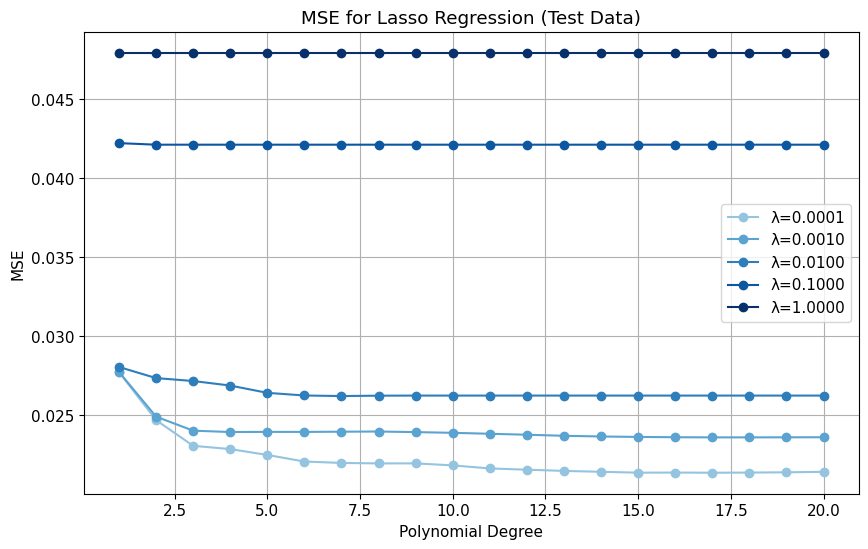

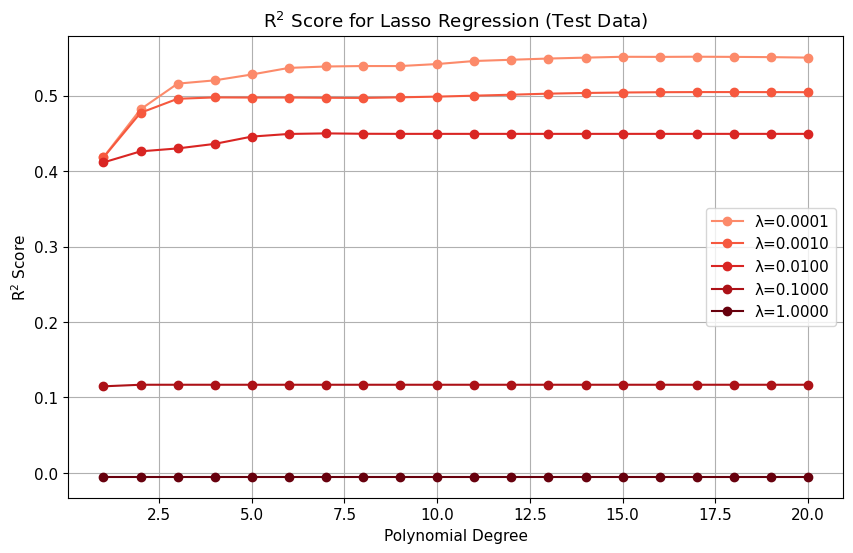

In [635]:
MSE_Lasso_train = np.zeros((len(degrees), len(lambdas)))
MSE_Lasso_test = np.zeros((len(degrees), len(lambdas)))
R2_Lasso_train = np.zeros((len(degrees), len(lambdas)))
R2_Lasso_test = np.zeros((len(degrees), len(lambdas)))

for i, deg in enumerate(degrees):
    X = create_X(x_scaled, y_scaled, n=deg)
    X = X[:, 1:]  # Remove the intercept

    X_train, X_test, z_train, z_test = train_test_split(X, z_scaled, test_size=0.2, random_state=1042)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean

    for j, lmb in enumerate(lambdas):

        lasso = Lasso(alpha=lmb, max_iter=10000)
        lasso.fit(X_train_scaled, z_train_scaled)

        y_train_pred = lasso.predict(X_train_scaled) + z_train_mean
        y_test_pred = lasso.predict(X_test_scaled) + z_train_mean

        MSE_Lasso_train[i, j] = mean_squared_error(z_train, y_train_pred)
        MSE_Lasso_test[i, j] = mean_squared_error(z_test, y_test_pred)
        R2_Lasso_train[i, j] = r2_score(z_train, y_train_pred)
        R2_Lasso_test[i, j] = r2_score(z_test, y_test_pred)

# Plotting results
plt.rcParams.update({'font.size': 11})

mse_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lambdas)))
plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, MSE_Lasso_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=mse_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for Lasso Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

r2_colors = plt.cm.Reds(np.linspace(0.4, 1, len(lambdas)))
plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, R2_Lasso_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=r2_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$ Score for Lasso Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

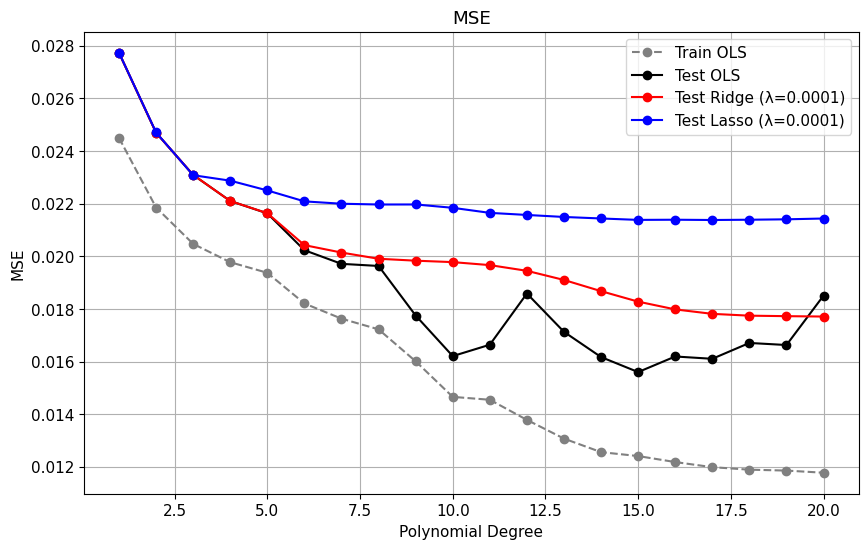

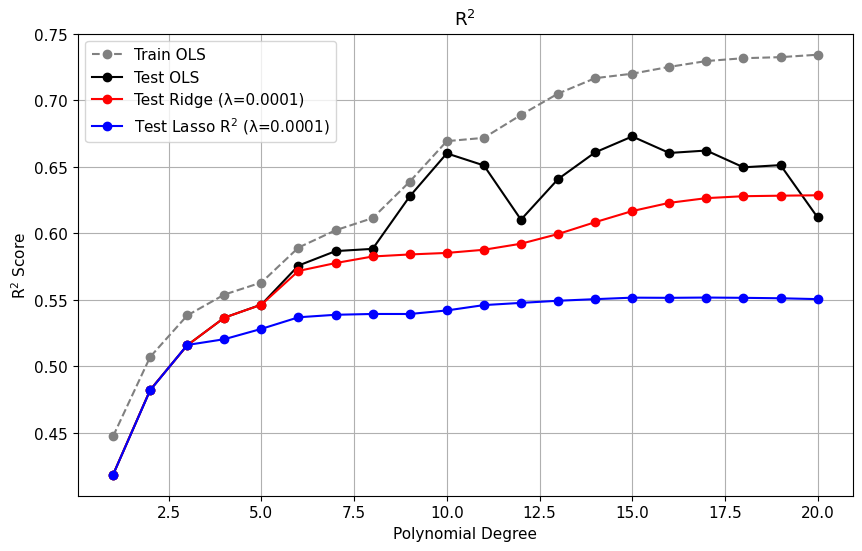

In [636]:
# best lambda value
lambda_value = 0.0001

plt.rcParams.update({'font.size': 11})

best_MSE_Ridge_test = MSE_Ridge_test[:, 0] 
best_MSE_Lasso_test = MSE_Lasso_test[:, 0]

best_R2_Ridge_test = R2_Ridge_test[:, 0]
best_R2_Lasso_test = R2_Lasso_test[:, 0]

plt.figure(figsize=(10, 6))
plt.plot(degrees, MSE_train_values, marker='o', color='grey', label='Train OLS', linestyle='--')
plt.plot(degrees, MSE_test_values, marker='o', color='black', label='Test OLS')
plt.plot(degrees, best_MSE_Ridge_test, marker='o', label='Test Ridge (λ=0.0001)', color='red')
plt.plot(degrees, best_MSE_Lasso_test, marker='o', label='Test Lasso (λ=0.0001)', color='blue')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE')
plt.legend()
plt.grid(True)
plt.show() 

plt.figure(figsize=(10, 6))
plt.plot(degrees, R2_train_values, marker='o', color='grey', label='Train OLS', linestyle='--')
plt.plot(degrees, R2_test_values, marker='o', label='Test OLS', color='black')
plt.plot(degrees, best_R2_Ridge_test, marker='o', label='Test Ridge (λ=0.0001)', color='red')
plt.plot(degrees, best_R2_Lasso_test, marker='o', label='Test Lasso R$^2$ (λ=0.0001)', color='blue')


plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$')
plt.legend()
plt.grid(True)
plt.show() 

In [637]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

Degree 1: Error = 0.0207, Bias ^2 = 0.0206, Variance = 0.0000
Degree 2: Error = 0.0193, Bias ^2 = 0.0193, Variance = 0.0001
Degree 3: Error = 0.0186, Bias ^2 = 0.0185, Variance = 0.0001
Degree 4: Error = 0.0182, Bias ^2 = 0.0180, Variance = 0.0002
Degree 5: Error = 0.0186, Bias ^2 = 0.0183, Variance = 0.0002
Degree 6: Error = 0.0175, Bias ^2 = 0.0172, Variance = 0.0003
Degree 7: Error = 0.0172, Bias ^2 = 0.0168, Variance = 0.0004
Degree 8: Error = 0.0172, Bias ^2 = 0.0166, Variance = 0.0005
Degree 9: Error = 0.0163, Bias ^2 = 0.0156, Variance = 0.0007
Degree 10: Error = 0.0156, Bias ^2 = 0.0146, Variance = 0.0010
Degree 11: Error = 0.0138, Bias ^2 = 0.0128, Variance = 0.0010
Degree 12: Error = 0.0139, Bias ^2 = 0.0123, Variance = 0.0016
Degree 13: Error = 0.0132, Bias ^2 = 0.0118, Variance = 0.0014
Degree 14: Error = 0.0137, Bias ^2 = 0.0116, Variance = 0.0021
Degree 15: Error = 0.0177, Bias ^2 = 0.0134, Variance = 0.0042
Degree 16: Error = 0.0237, Bias ^2 = 0.0160, Variance = 0.0078
D

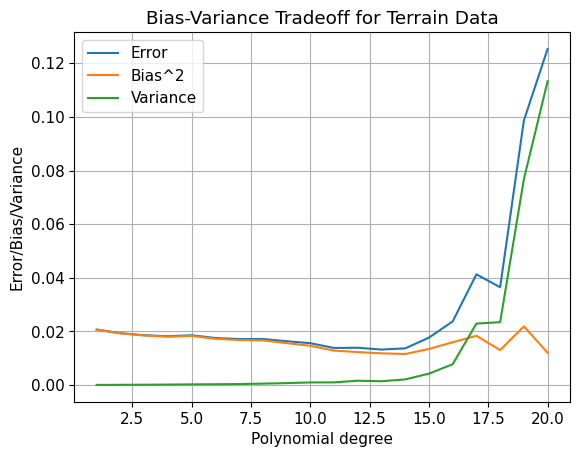

In [655]:
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

n_boostraps = 100
maxdegree = 20

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.arange(1, maxdegree + 1)

z_test = z_test.reshape(-1, 1)

for degree in range(1, maxdegree + 1):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    z_pred = np.empty((z_test.shape[0], n_boostraps))

    for i in range(n_boostraps):
        X_, z_ = resample(X_train, z_train)
        z_pred[:, i] = model.fit(X_, z_).predict(X_test).ravel()

    error[degree-1] = np.mean(np.mean((z_test - z_pred) ** 2, axis=1))
    bias[degree-1] = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True)) ** 2)
    variance[degree-1] = np.mean(np.var(z_pred, axis=1))

    print(f'Degree {degree}: Error = {error[degree-1]:.4f}, Bias ^2 = {bias[degree-1]:.4f}, Variance = {variance[degree-1]:.4f}')
    
plt.rcParams.update({'font.size': 11})

plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='Bias^2')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Polynomial degree')
plt.ylabel('Error/Bias/Variance')
plt.legend()
plt.title('Bias-Variance Tradeoff for Terrain Data')
plt.grid(True)
plt.show()


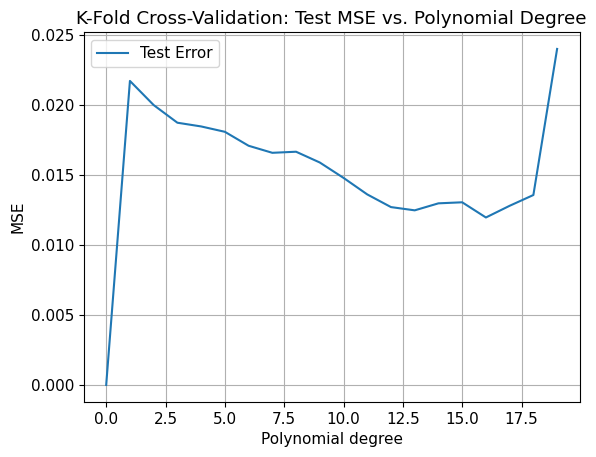

In [659]:
from sklearn.model_selection import KFold, cross_val_score

Maxpolydegree = 20
estimated_mse_sklearn = np.zeros(Maxpolydegree)
polynomial = np.zeros(Maxpolydegree)

k = 10
kfold = KFold(n_splits=k)

for polydegree in range(1, Maxpolydegree):
    polynomial[polydegree] = polydegree
    X = create_X(x_scaled, y_scaled, polydegree)
    OLS = LinearRegression(fit_intercept=False)
    estimated_mse_folds = cross_val_score(OLS, X, z_scaled, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[polydegree] = np.mean(-estimated_mse_folds)

plt.rcParams.update({'font.size': 11})
plt.plot(polynomial, estimated_mse_sklearn, label='Test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.title('K-Fold Cross-Validation: Test MSE vs. Polynomial Degree')
plt.show()
